# Re-parametrizing the Ostriker model to increase flexibility

Trying to fit the Ostriker polytropic model on hydro simulations can lead to a puzzling result: even when trying to fit them jointly, it looks impossible to get a satisfying fit on the gas density and pressure. Let's highlight the problem and offer a solution by re-parametrizing the polytropic model to break the $(\rho_0, P_0)$ degeneracy.

In [16]:
%matplotlib widget

In [17]:
import jax.numpy as jnp
from jax import jit, grad, value_and_grad
import optax
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from tqdm import trange

import sys
sys.path.append("..")
from picasso import cic, utils
import picasso.polytrop as pp
import picasso.polytrop_ostriker as ppo

cosmo = FlatLambdaCDM(67.66, 0.30964, Ob0=0.04897)
norms = {"rho": 1e14, "P": 1e20}

def read_hdf5(file_name, jax=False):
    arr_func = jnp.array if jax else np.array
    with h5py.File(file_name, "r") as f:
        grids = {k: arr_func(v) for k, v in f.items()}
    return grids

## Reading in data

We'll use data from the 576 runs. Specifically, we will take a random halo in the lightcone shell from step 567 ($z \simeq 0.1$).

In [18]:
path = "/Users/fkeruzore/Data/HACC/576/LIGHTCONE"
step = "567"

halos_ad = read_hdf5(f"{path}/AD/halos_{step}.h5")
halos_go = read_hdf5(f"{path}/GO/halos_{step}.h5")
pairs = Table.read(f"{path}/PAIRS/halos_{step}.h5", format="hdf5")
parts_ad = read_hdf5(f"{path}/AD/sodbighaloparticles_{step}.h5")
parts_go = read_hdf5(f"{path}/GO/sodbighaloparticles_{step}.h5")

In [19]:
def get_data(i_pair, r_edges_R500, verbose=False):

    # Halo properties
    pair = pairs[i_pair]
    i_go = np.where((halos_go["fof_halo_tag"] == pair["GO"]))[0][0]
    i_ad = np.where((halos_ad["fof_halo_tag"] == pair["AD"]))[0][0]
    h_go = {k: v[i_go] for k, v in halos_go.items()}
    h_ad = {k: v[i_ad] for k, v in halos_ad.items()}

    a = h_go["fof_halo_center_a"]
    z = 1.0 / a - 1.0
    adot = (cosmo.H(z) * a).to("km s-1 Mpc-1").value / cosmo.h

    if verbose:
        print("====   HALO PROPERTIES  ====")
        print(f"{z=:.3f} ({a=:.3f})")
        print("-------   GRAV-ONLY  -------")
        print(f"M500 = {h_go['sod_halo_M500c']:.2e} h-1 Msun")
        print(f"R500 = {h_go['sod_halo_R500c']:.3f} h-1 cMpc")
        print("-------   ADIABATIC  -------")
        print(f"M500 = {h_ad['sod_halo_M500c']:.2e} h-1 Msun")
        print(f"R500 = {h_ad['sod_halo_R500c']:.3f} h-1 cMpc")

    # Gravity-only particles
    wp_go = parts_go["fof_halo_tag"] == pair["GO"]
    p_go = {k: v[wp_go] for k, v in parts_go.items()}

    p_go["r"] = np.sqrt(
          np.fmod((576.0 + p_go["x"] - h_go["fof_halo_center_x"]), 576.0) ** 2
        + np.fmod((576.0 + p_go["y"] - h_go["fof_halo_center_y"]), 576.0) ** 2
        + np.fmod((576.0 + p_go["z"] - h_go["fof_halo_center_z"]), 576.0) ** 2
    )  # comoving distance from center, h-1 cMpc
    p_go["v2"] = (
        ((a * p_go["vx"] + adot * p_go["x"]) - (a * h_go["fof_halo_com_vx"] + adot * h_go["fof_halo_center_x"])) ** 2
        + ((a * p_go["vy"] + adot * p_go["y"]) - (a * h_go["fof_halo_com_vy"] + adot * h_go["fof_halo_center_y"])) ** 2
        + ((a * p_go["vz"] + adot * p_go["z"]) - (a * h_go["fof_halo_com_vz"] + adot * h_go["fof_halo_center_z"])) ** 2
    )  # proper squared velocity, km2 s-2
    p_go["phi"] -= p_go["phi"].min() 
    p_go["mass"] = np.ones_like(p_go["x"]) * 1.3428e09  # h-1 Msun

    # Adiabatic particles
    wp_ad = parts_ad["fof_halo_tag"] == pair["AD"]
    p_ad = {k: v[wp_ad] for k, v in parts_ad.items()}
    p_ad["r"] = np.sqrt(
          np.fmod((576.0 + p_ad["x"] - h_ad["fof_halo_center_x"]), 576.0) ** 2
        + np.fmod((576.0 + p_ad["y"] - h_ad["fof_halo_center_y"]), 576.0) ** 2
        + np.fmod((576.0 + p_ad["z"] - h_ad["fof_halo_center_z"]), 576.0) ** 2
    )  # comoving distance from center, h-1 cMpc
    p_ad["v2"] = (
        ((a * p_ad["vx"] + adot * p_ad["x"]) - (a * h_ad["fof_halo_com_vx"] + adot * h_ad["fof_halo_center_x"])) ** 2
        + ((a * p_ad["vy"] + adot * p_ad["y"]) - (a * h_ad["fof_halo_com_vy"] + adot * h_ad["fof_halo_center_y"])) ** 2
        + ((a * p_ad["vz"] + adot * p_ad["z"]) - (a * h_ad["fof_halo_com_vx"] + adot * h_ad["fof_halo_center_z"])) ** 2
    )  # proper squared velocity, km2 s-2
    p_ad["is_gas"] = (  # part is gas if part:
        (np.bitwise_and(p_ad["mask"], 2**2) > 0)  # is not CDM
        & (np.bitwise_and(p_ad["mask"], 2**3) == 0)  # is not AGN
        & (np.bitwise_and(p_ad["mask"], 2**4) == 0)  # is not star
        & (np.bitwise_and(p_ad["mask"], 2**5) == 0)  # is not wind
    )
    p_ad["P_th"] = (2 / 3) * p_ad["rho"] * p_ad["uu"]
    p_ad["P_nt"] = (1 / 3) * p_ad["rho"] * p_ad["v2"]
    for p in ["P_th", "P_nt"]:
        p_ad[p] = np.where(p_ad["is_gas"], p_ad[p], np.nan)
    p_ad_g = {k: v[p_ad["is_gas"]] for k, v in p_ad.items()}

    _, rho_ad_1d, drho_ad_1d = utils.azimuthal_profile(
        p_ad_g["rho"] / norms["rho"],
        p_ad_g["r"] / h_ad["sod_halo_R500c"],
        r_edges_R500,
    )
    _, P_ad_1d, dP_ad_1d = utils.azimuthal_profile(
        (p_ad_g["P_th"] + p_ad_g["P_nt"]) / norms["P"],
        p_ad_g["r"] / h_ad["sod_halo_R500c"],
        r_edges_R500,
    )

    p_go_0 = {k: v[p_go["r"] < (r_edges_R500[1] * h_go["sod_halo_R500c"])] for k, v in p_go.items()}
    rho_0_go = np.sum(p_go_0["mass"]) / ((4.0 / 3.0) * np.pi * (h_go["sod_halo_R500c"] * a)**3)  # h2 Msun Mpc-3
    P_0_go = rho_0_go * np.mean(p_go_0["v2"]) * 2 / 3.0  # h2 Msun Mpc-3 km2 s-2

    return {
        "r": p_go["r"] / h_go["sod_halo_R500c"],
        "phi": p_go["phi"],
        "rho": rho_ad_1d,
        "drho": drho_ad_1d,
        "P": P_ad_1d,
        "dP": dP_ad_1d,
    }


## Fitting the model

### Original Ostriker model

In the original Ostriker model, gas density and pressure are parametrized as a function of gravitational potential:

$$
\theta(\phi) = 1 - \frac{\Gamma - 1}{\Gamma} \frac{\rho_0}{P_0} (\phi - \phi_0), \\[10pt]
\rho(\phi) = \rho_0 \theta^{\Gamma / (\Gamma - 1)}(\phi), \\[10pt]
P(\phi) = P_0 \theta^{1 / (\Gamma - 1)}(\phi),
$$

where the three model parameters are $(\rho_0, P_0)$, the central gas density and pressure, and $\Gamma$, the adiabatic index of the gas.

The pasting model relies on fixing $\Gamma$, and solving for conservation of gas density and pressure during a rearrangement of the gas to obtain $(\rho_0, P_0)$.
Instead, we can fit the functional form of the Ostriker model from the gravity-only potential and see how well that works.

The fit will be done on azimuthal profiles of gas density and pressure: for a given set of parameters $\vartheta = (\rho_0, P_0, \Gamma)$, gas density and pressure are computed from the potential values in the gravity-only run. Then, these are azimuthally averaged, which is compared to the azimuthally-averaged gas density and pressure in the hydro run:

$$
\chi^2_\rho(\vartheta) = \left(\frac{\rho_{\rm BP}(\vartheta) - \rho_{\rm HY}}{\Delta\rho_{\rm HY}}\right)^2, \\[10pt]
\chi^2_P(\vartheta) = \left(\frac{P_{\rm BP}(\vartheta) - P_{\rm HY}}{\Delta P_{\rm HY}}\right)^2,
$$

where $\Delta \rho_{\rm HY}$ and $\Delta P_{\rm HY}$ are the standard deviation of gas density and pressure across particles in each radius shell.

We will run the fit using gradient descent, for three different loss functions:
1. Fit on gas density only: ${\rm loss}(\vartheta) = \chi^2_\rho(\vartheta)$;
2. Fit on gas pressure only: ${\rm loss}(\vartheta) = \chi^2_P(\vartheta)$;
3. Fit on both jointly: ${\rm loss}(\vartheta) = \frac{1}{2} \left(\chi^2_\rho(\vartheta) + \chi^2_P(\vartheta)\right)$.

In [20]:
def fit(i_pair, r_edges_R500, optimizer, n_steps, which="both"):
    data = get_data(i_pair, r_edges_R500, verbose=False)

    def compute_model(par):
        rho_0, P_0 = 10**par[:2]
        Gamma = par[2]
        rho_mod_3d, P_mod_3d = ppo.rho_P_g(data["phi"], rho_0, P_0, Gamma)
        _, rho_mod_1d, _ = utils.azimuthal_profile(rho_mod_3d / norms["rho"], data["r"], r_edges_R500)
        _, P_mod_1d, _ = utils.azimuthal_profile(P_mod_3d / norms["P"], data["r"], r_edges_R500)
        return rho_mod_1d, P_mod_1d

    if which == "P":
        def loss_fn(par):
            rho_mod, P_mod = compute_model(par)
            return jnp.mean(((data["P"] - P_mod) / data["dP"])**2)
    elif which == "rho":
        def loss_fn(par):
            rho_mod, P_mod = compute_model(par)
            return jnp.mean(((data["rho"] - rho_mod) / data["drho"])**2)
    elif which == "both":
        def loss_fn(par):
            rho_mod, P_mod = compute_model(par)
            return 0.5 * (
                jnp.mean(((data["rho"] - rho_mod) / data["drho"])**2)
                + jnp.mean(((data["P"] - P_mod) / data["dP"])**2)
            )

    rho_0, P_0 = data["rho"][0] * norms["rho"], data["P"][0] * norms["P"]
    par_i = jnp.array([
        jnp.log10(rho_0), jnp.log10(P_0), 1.2
    ])

    opt_state = optimizer.init(par_i)
    chain = []

    @jit
    def step(par, opt_state):
        loss_value, grads = value_and_grad(loss_fn)(par)
        updates, opt_state = optimizer.update(grads, opt_state, par)
        par = optax.apply_updates(par, updates)
        return par, opt_state, loss_value

    par = par_i.copy()
    for i in range(n_steps):
        par, opt_state, loss_value = step(par, opt_state)
        chain.append([*par, loss_value])
        # if i % (n_steps / 5) == 0:
        #     print(f"Step {i}; Loss: {loss_value:.5f}")

    chain = jnp.array(chain)
    rho_fit, P_fit = compute_model(chain[-1, :-1])
    return {
        "chain": chain,
        "rho_fit": rho_fit,
        "P_fit": P_fit,
        **data
    }

def plot_results(results, r_R500):
    fig_profs = plt.figure(figsize=(12, 6))
    gs = GridSpec(2, 2, height_ratios=[2, 1])
    axs_dat = [fig_profs.add_subplot(gs[0]), fig_profs.add_subplot(gs[1])]
    axs_res = [fig_profs.add_subplot(gs[2]), fig_profs.add_subplot(gs[3])]

    for res in results:
        rho, drho = res["rho"] * norms["rho"], res["drho"] * norms["rho"]
        P, dP = res["P"] * norms["P"], res["dP"] * norms["P"]

        axs_dat[0].errorbar(r_R500, rho, yerr=drho, fmt="o", capsize=3, color="k", mec="w")
        axs_dat[1].errorbar(r_R500, P, yerr=dP, fmt="o", capsize=3, color="k", mec="w")
        axs_res[0].errorbar(r_R500, np.zeros_like(rho), yerr=drho / rho, fmt="o", capsize=3, color="k", mec="w")
        axs_res[1].errorbar(r_R500, np.zeros_like(P), yerr=dP / P, fmt="o", capsize=3, color="k", mec="w")

        rho_fit, P_fit = res["rho_fit"] * norms["rho"], res["P_fit"] * norms["P"]
        axs_dat[0].plot(r_R500, rho_fit, lw=2, zorder=5, label=res["name"])
        axs_dat[1].plot(r_R500, P_fit, lw=2, zorder=5, label=res["name"])
        axs_res[0].plot(r_R500, rho_fit / rho - 1, lw=2, zorder=5)
        axs_res[1].plot(r_R500, P_fit / P - 1, lw=2, zorder=5)

    for ax in axs_dat:
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.xaxis.set_ticks_position("both")
        ax.yaxis.set_ticks_position("both")
        ax.grid(":")
        ax.set_xticklabels([])
    for ax in axs_res:
        ax.set_xscale("log")
        ax.xaxis.set_ticks_position("both")
        ax.yaxis.set_ticks_position("both")
        ax.grid(":")
        ax.set_xlabel("$r / R_{500c}$")
        ax.set_ylim(-1, 1)

    axs_dat[0].set_ylabel("$\\rho_{\\rm g} \\; [h^2 M_\\odot {\\rm Mpc^{-3}}]$")
    axs_dat[1].set_ylabel("$P_{\\rm g} \\; [h^2 M_\\odot {\\rm Mpc^{-3} km^2 s^{-2}}]$")
    axs_res[0].set_ylabel("$\\Delta \\rho / \\rho$")
    axs_res[1].set_ylabel("$\\Delta \\rho / \\rho$")
    fig_profs.align_labels()
    axs_dat[1].legend()

    if results[0]["chain"].shape[1] == 5:
        params_names = ["$\\rho_0$", "$P_0$", "$\\Gamma$", "$\\theta_0$", "loss"]
    else:
        params_names = ["$\\rho_0$", "$P_0$", "$\\Gamma$", "loss"]

    fig_chain, axs_chain = plt.subplots(len(params_names), 1, figsize=(7, 6))
    for i, ax in enumerate(axs_chain):
        for res in results:
            chain = res["chain"]
            ax.plot(chain[:, i], label=res["name"])
        ax.set_ylabel(params_names[i])
        if i == chain.shape[1] - 1:
            ax.set_xlabel("Step")
            ax.set_yscale("log")
        else:
            ax.set_xticklabels([])
        ax.grid(":")
    fig_chain.align_labels()
    axs_chain[-1].legend()

    return fig_profs, fig_chain


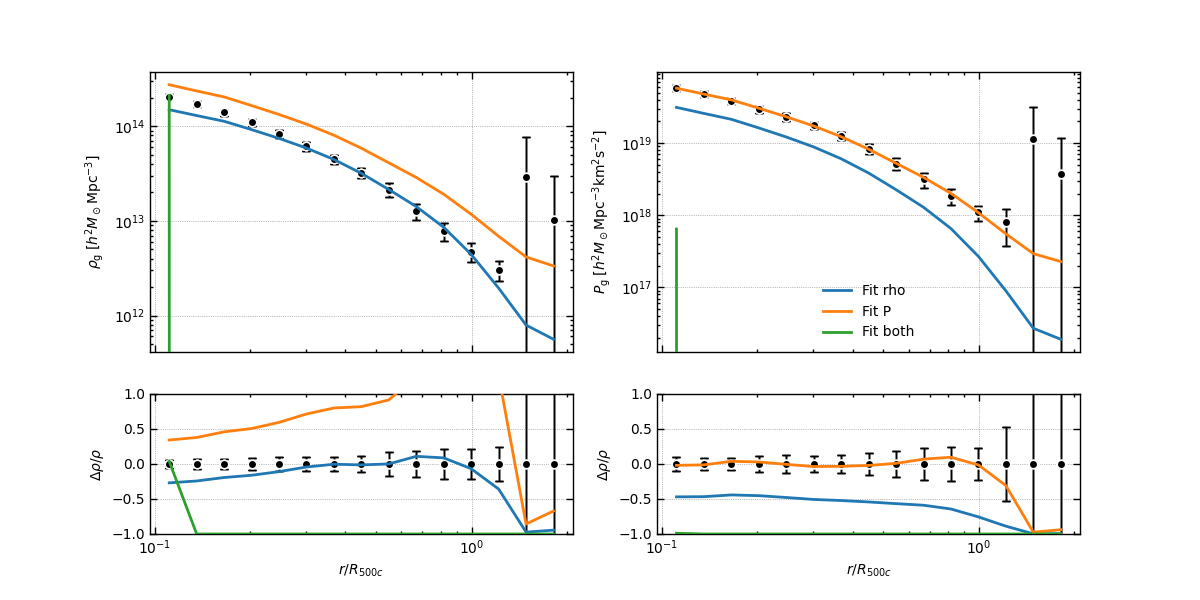

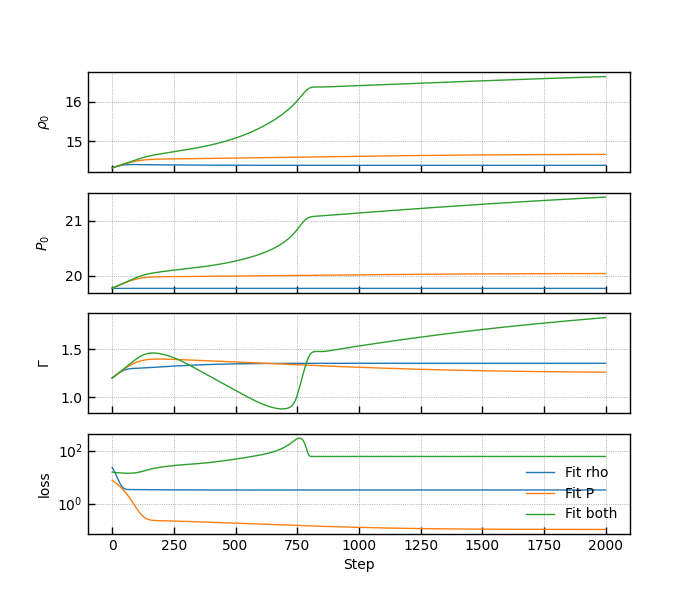

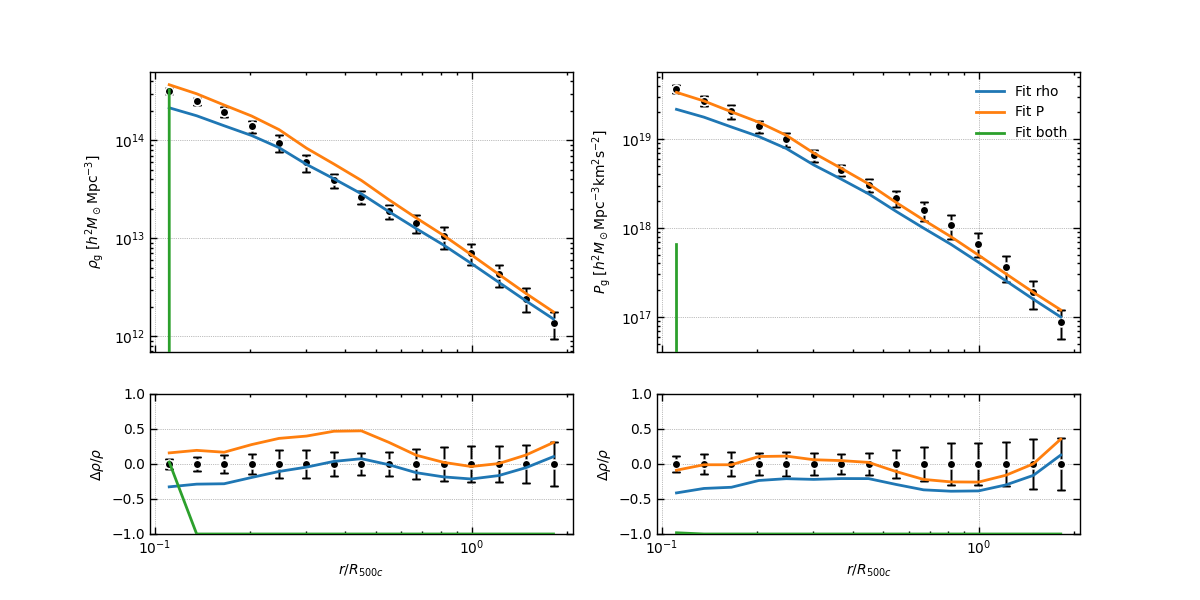

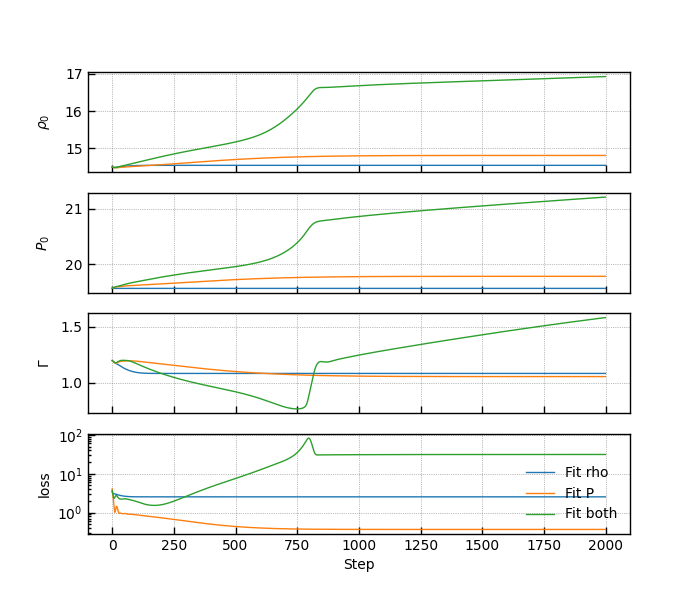

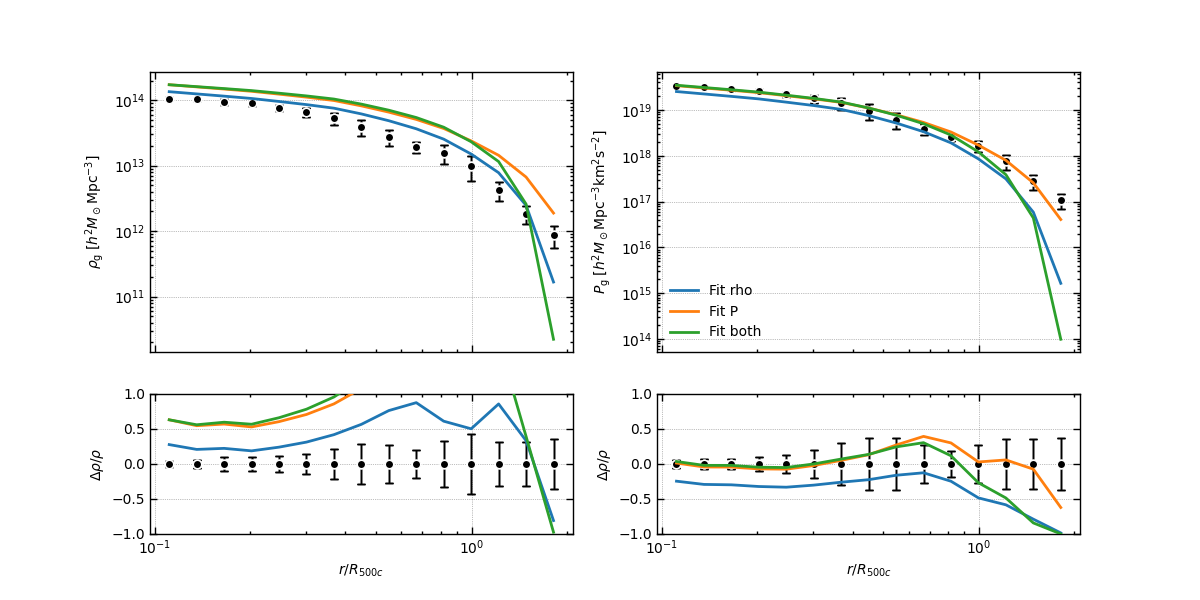

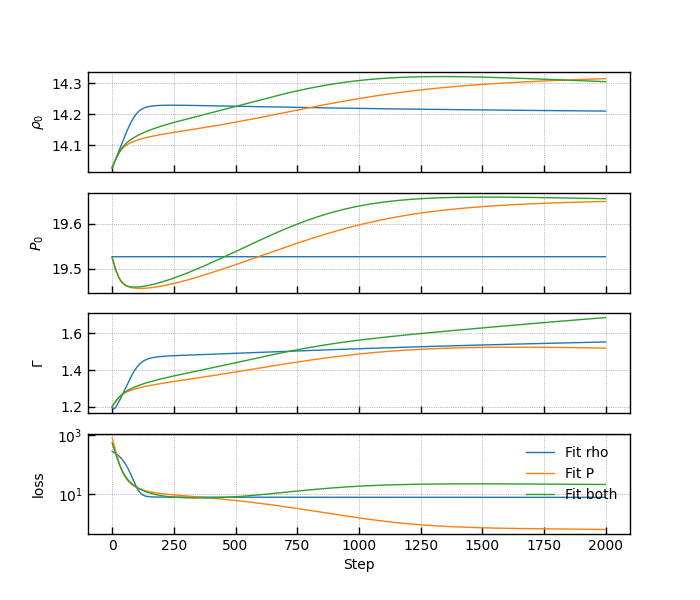

In [21]:
plt.close("all")
r_edges_R500 = np.logspace(-1.0, 0.3, 16)
r_R500 = r_edges_R500[:-1] + 0.5 * np.ediff1d(r_edges_R500)
i_pairs = np.random.randint(0, len(halos_ad), 3)

for i_pair in i_pairs:
    res = [
        {**fit(i_pair, r_edges_R500, optax.adam(learning_rate=2e-3), 2000, which=which), "name": f"Fit {which}"}
        for which in ["rho", "P", "both"] 
    ]
    figs = plot_results(res, r_R500)

What we see is that, in most cases, fitting for density or pressure gives different values for parameters, resulting in discrepancies: fitting for density gives a good fit of density, but not of pressure, and vice-versa. The joint fit does not seem to help.

A possible explanation could be the inherent degeneracy between parameters in the Ostriker formulation. In these equations, $(\rho_0, P_0, \Gamma)$ are the central value of gas density, pressure, and the gas adiabatic index, respectively; but they also all intervene in the normalization of the gravitational potential in the computation of $\theta$. As a result, changing one of the parameters (e.g. $P_0$) does not only change the pressure normalization, but also the whole shape of both density and pressure.

### Re-parametrizing

One way to address this question is to change the parametric form of the Ostriker model.
Specifically, we can change $\theta(\phi)$ to:

$$
\theta'(\phi) = 1 - \theta_0 (\phi - \phi_0),
$$

where $\theta_0$ is a new model parameter. This formulation is equivalent to the original Ostriker model for

$$
\theta_0 = \frac{\Gamma - 1}{\Gamma} \frac{\rho_0}{P_0}.
$$

With this re-parametrization, we can rewrite gas density and pressure simply as:

$$
\rho(\phi) = \rho_0 \theta'^{\Gamma / (\Gamma - 1)}(\phi), \\[10pt]
P(\phi) = P_0 \theta'^{1 / (\Gamma - 1)}(\phi),
$$

and $(\rho_0, P_0, \Gamma)$ 

In [22]:
def fit(i_pair, r_edges_R500, optimizer, n_steps):
    data = get_data(i_pair, r_edges_R500, verbose=False)

    def compute_model(par):
        rho_0, P_0 = 10**par[:2]
        Gamma = par[2]
        theta_0 = 10**par[3]
        rho_mod_3d, P_mod_3d = pp.rho_P_g(data["phi"], rho_0, P_0, Gamma, theta_0)
        _, rho_mod_1d, _ = utils.azimuthal_profile(rho_mod_3d / norms["rho"], data["r"], r_edges_R500)
        _, P_mod_1d, _ = utils.azimuthal_profile(P_mod_3d / norms["P"], data["r"], r_edges_R500)
        return rho_mod_1d, P_mod_1d

    def loss_fn(par):
        rho_mod, P_mod = compute_model(par)
        return 0.5 * (
            jnp.mean(((data["rho"] - rho_mod) / data["drho"])**2)
            + jnp.mean(((data["P"] - P_mod) / data["dP"])**2)
        )

    rho_0, P_0 = data["rho"][0] * norms["rho"], data["P"][0] * norms["P"]
    par_i = jnp.array([
        jnp.log10(rho_0), jnp.log10(P_0), 
        1.2, jnp.log10(rho_0 / P_0)
    ])

    opt_state = optimizer.init(par_i)
    chain = []

    @jit
    def step(par, opt_state):
        loss_value, grads = value_and_grad(loss_fn)(par)
        updates, opt_state = optimizer.update(grads, opt_state, par)
        par = optax.apply_updates(par, updates)
        return par, opt_state, loss_value

    par = par_i.copy()
    for i in range(n_steps):
        par, opt_state, loss_value = step(par, opt_state)
        chain.append([*par, loss_value])
        # if i % (n_steps / 5) == 0:
        #     print(f"Step {i}; Loss: {loss_value:.5f}")

    chain = jnp.array(chain)
    rho_fit, P_fit = compute_model(chain[-1, :-1])
    return {
        "chain": chain,
        "rho_fit": rho_fit,
        "P_fit": P_fit,
        **data
    }

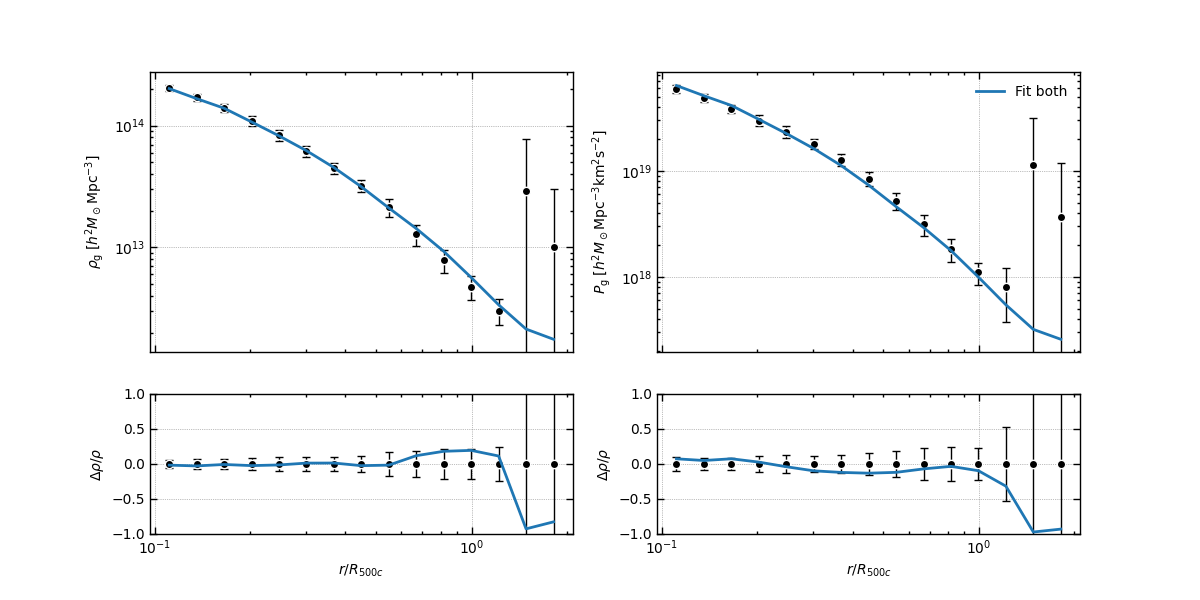

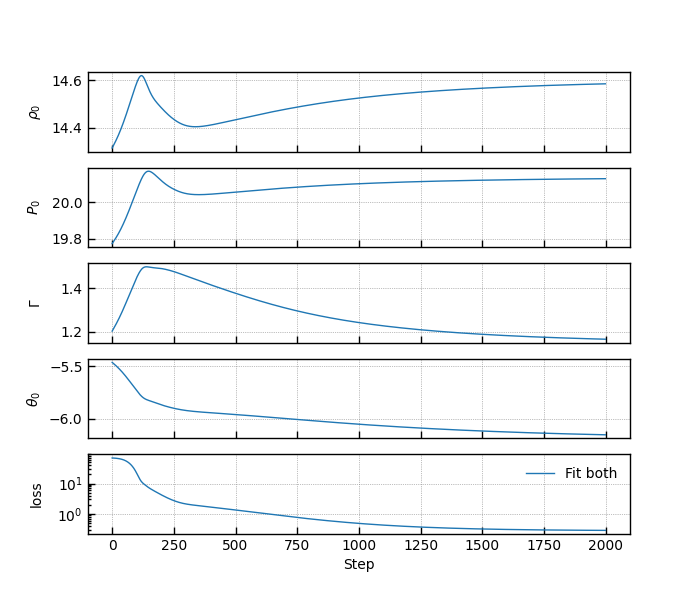

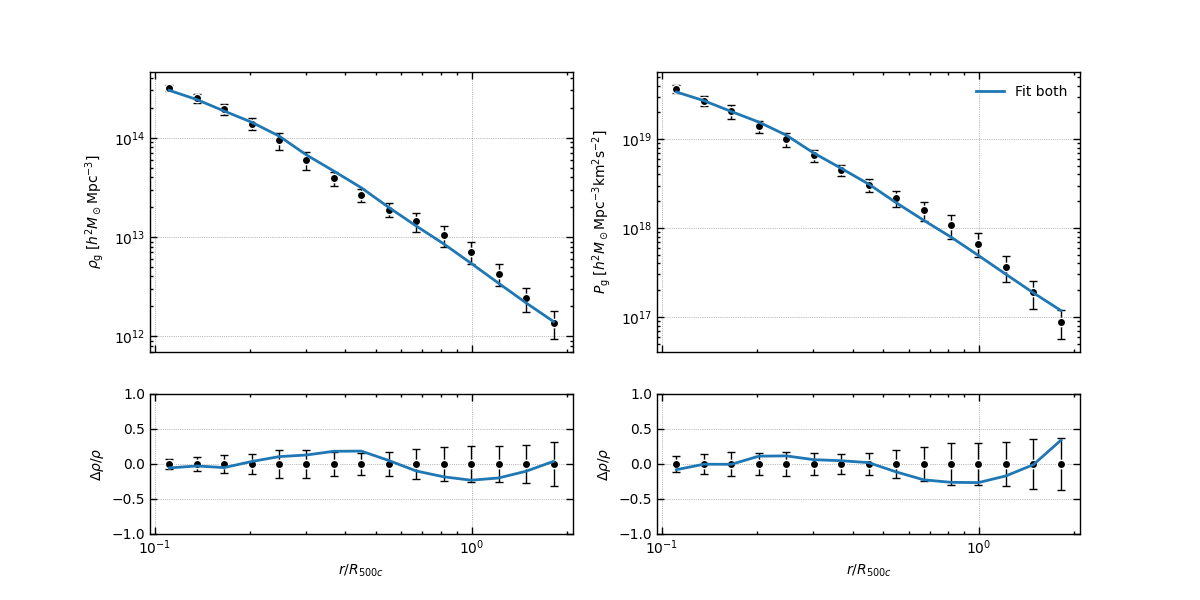

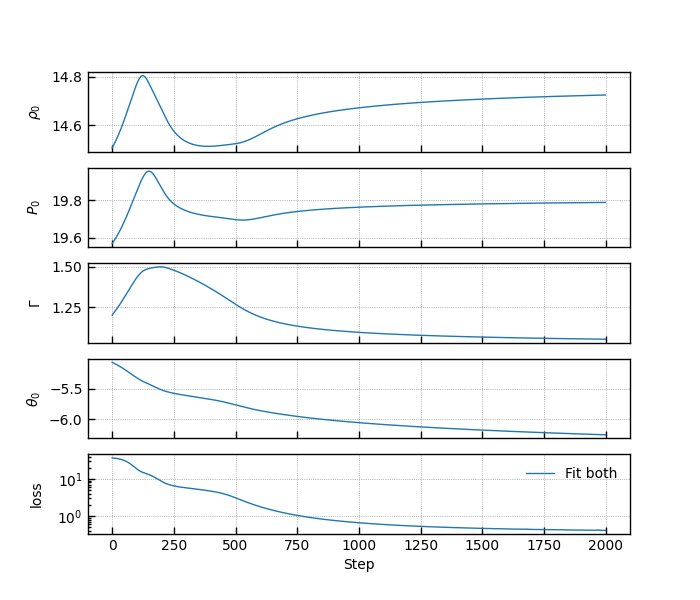

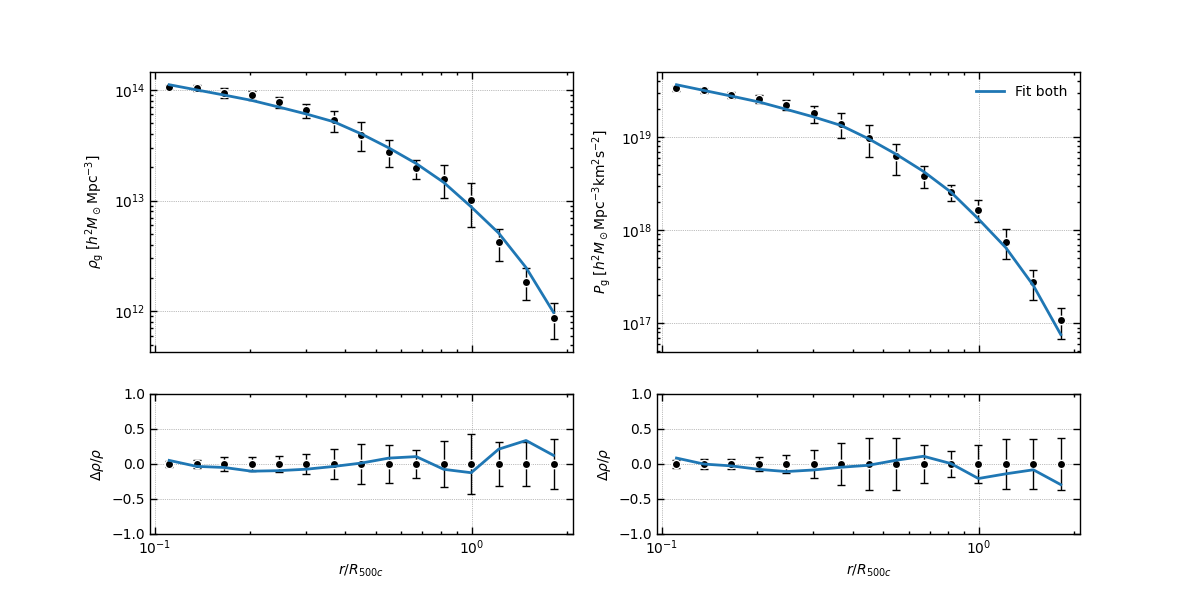

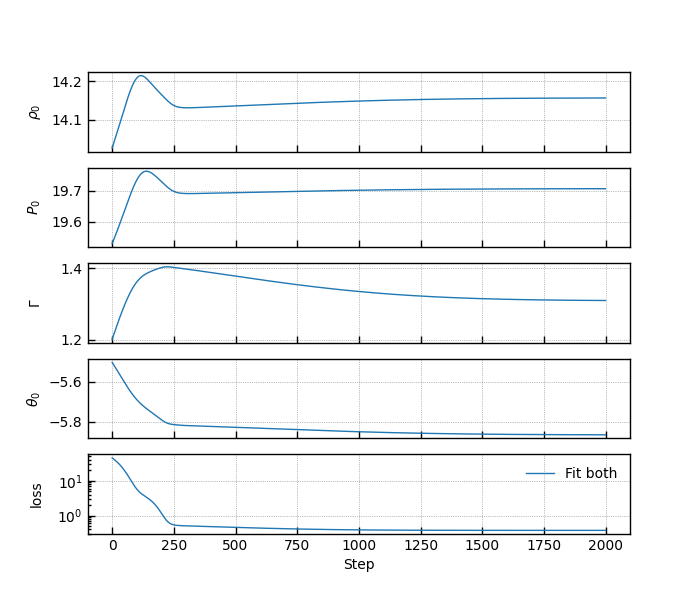

In [23]:
for i_pair in i_pairs:
    res = [{**fit(i_pair, r_edges_R500, optax.adam(learning_rate=2e-3), 2000), "name": "Fit both"}]
    figs = plot_results(res, r_R500)
